In [75]:
%%capture
import numpy
import scipy
import matplotlib
import matplotlib.pyplot as plt
from copy import copy
import os
import neo
import neo.io.nestio as nestio
import elephant
import quantities as pq
import numpy as np
import sys
import seaborn as sns
sns.set(context='talk', style='ticks')
%matplotlib inline

to run in the collab:

to run locally:

In [2]:
import sciunit

# sys.path.insert(0, "/home/denker/Projects/viziphant")
sys.path.insert(0, "/home/rgutzen/Projects/viziphant")
import viziphant.rasterplot

# sys.path.insert(0, "/home/denker/Projects/toolboxes/py/NetworkUnit")
sys.path.insert(0, "/home/rgutzen/Projects/NetworkUnit")
from networkunit import scores, models, tests, plots, capabilities
from networkunit.scores import to_precision

## Define model classes
#### WavescalES class

In [3]:
class wavescales_data(models.spiketrain_data):
    file_path = None
    params = {'gridsize':(24,24),
              'filter_dpsnn_ids':[],
              'filter_nest_ids':[],
              'filter_type':None,
              'filter_module':None,
              'align_to_0':False
             }
    
    def filter_type(self, spiketrains, filter_type=None, **kwargs):
        # additional utility function
        if type(filter_type) == str:
            filter_type = [filter_type]
        spiketrains = list(filter(lambda st: st.annotations['sub_population'] 
                                   in filter_type, spiketrains))
        return spiketrains
    
    def filter_module(self, spiketrains, filter_module=None, **kwargs):
        # additional utility function
        if type(filter_module) == int:
            filter_module = [filter_module]
        spiketrains = list(filter(lambda st: st.annotations['grid_position'][0]*self.params['gridsize'][0] 
                                           + st.annotations['grid_position'][1]
                                       in filter_module, spiketrains))
        return spiketrains
    
    
    def mapping(self, nest_id=None, dpsnn_id=None):
        A = self.params['gridsize'][0]
        B = self.params['gridsize'][1]

        if nest_id is not None and dpsnn_id is None:
            type_separator = (nest_id-2) // (A*B)
        elif dpsnn_id is not None and nest_id is None:
            type_separator = dpsnn_id % 1250
        else:
            raise ValueError('Only pass either a NEST id or a DPSNN id!')

        if type_separator < 250:
            subpop = 'EXF'
            subpopsize = 250
            typeID = 0
        elif type_separator < (250+750):
            subpop = 'EXB'
            subpopsize = 750
            typeID = 250
        else:
            subpop = 'INH'
            subpopsize = 250
            typeID = 250+750
            
        nest_shift = 2 + typeID * A*B          

        if nest_id is not None and dpsnn_id is None:
            intypeID = nest_id - nest_shift
            insubpopID = intypeID % subpopsize # [0, subpopsize]
            grid_num = intypeID // subpopsize # [0,AxB]  == a + b*A
            dpsnn_id = 1250 * grid_num + insubpopID + typeID
            
        elif dpsnn_id is not None and nest_id is None:
            insubpopID = type_separator - typeID
            grid_num = dpsnn_id // 1250    # [0,AxB]
            nest_id = nest_shift + subpopsize*grid_num + insubpopID    

        a = grid_num % A         # [0,A]
        b = grid_num // A        # [0,B]
        return (dpsnn_id, nest_id, subpop, (a,b))

#### DPSNN class

In [26]:
class dpsnn_wavescales_data(wavescales_data):
    file_path = None
    params = copy(wavescales_data.params)

    def load(self, file_path, filter_dpsnn_ids=[], filter_nest_ids=[], 
             filter_type=None, filter_module=None, in_collab=False, **kwargs):
        if filter_nest_ids and not filter_dpsnn_ids:
            filter_dpsnn_ids = [self.mapping(nest_id=i)[1] for i in filter_nest_ids]
        if filter_type is not None or filter_module is not None:
            if not filter_dpsnn_ids:
                filter_dpsnn_ids = list(range(1250*self.params['gridsize'][0]*self.params['gridsize'][1]))
            if filter_type is not None:
                filter_dpsnn_ids = list(filter(lambda i: self.mapping(dpsnn_id=i)[2] in filter_type, filter_dpsnn_ids))
        if filter_module is not None:
                filter_dpsnn_ids = list(filter(lambda i: self.mapping(dpsnn_id=i)[3][0]*self.params['gridsize'][0]
                                                       + self.mapping(dpsnn_id=i)[3][1] in filter_module, filter_dpsnn_ids))
        if in_collab:
            store_path = './DPSNN/' + os.path.split(file_path)[-1]
            client.download_file(file_path, store_path)
            file_path = store_path
            
        neo_obj = nestio.NestIO(file_path)
        neo_block = neo_obj.read_block(gid_list=filter_dpsnn_ids, t_start = 0*pq.s, t_stop = 10*pq.s)
        spiketrains = neo_block.segments[0].spiketrains
        for st_count, st in enumerate(spiketrains):
                dpsnn_id, nest_id, subpop, gridpos = self.mapping(dpsnn_id=st.annotations['id'])
                spiketrains[st_count].annotate(dpsnn_id = dpsnn_id)
                spiketrains[st_count].annotate(sub_population = subpop)
                spiketrains[st_count].annotate(grid_position = gridpos)
                spiketrains[st_count].annotate(module = gridpos[0]*self.params['gridsize'][0] + gridpos[1])
                spiketrains[st_count].annotate(nest_id = nest_id) 
#         spiketrains = list(filter(lambda st: st.any(), spiketrains)) # remove empty spike trains
        return spiketrains

#### NEST class

In [67]:
class nest_wavescales_data(wavescales_data):
    file_path = None
    params = copy(wavescales_data.params)
    
    def load(self, file_path, filter_dpsnn_ids=[], filter_nest_ids=[], 
             filter_type=None, filter_module=None, in_collab=False, **kwargs):
        if in_collab: # if in_collab, always all files are read
            store_path = './NEST/'
            for i in range(144):
                fname = 'spikeTotal-721206-{}.gdf'.format(str(i).zfill(3))
                client.download_file(file_path + fname, store_path + fname)
            file_path = store_path   
        if os.path.isfile(file_path):
            dir_path, filename = os.path.split(file_path)
            dir_path = dir_path + '/'
            file_names = [filename]
        elif os.path.isdir(file_path) or in_collab: # quickfix! needs to be improved
            dir_path = file_path + '/'
            file_names = []
            for name in os.listdir(file_path):
                if name.split('.')[-1] == 'gdf':
                    file_names += [name]
        else:
            raise ImportError('No valid file path provided!')
                    
        spiketrain_list = []
        
        if filter_dpsnn_ids and not filter_nest_ids:
            filter_nest_ids = [self.mapping(dpsnn_id=i)[1] for i in filter_dpsnn_ids]
        if filter_type is not None or filter_module is not None:
            if not filter_nest_ids:
                filter_nest_ids = list(range(1250*self.params['gridsize'][0]*self.params['gridsize'][1]))
            if filter_type is not None:
                filter_nest_ids = list(filter(lambda i: self.mapping(nest_id=i)[2] in filter_type, filter_nest_ids))
            if filter_module is not None:
                filter_nest_ids = list(filter(lambda i: self.mapping(nest_id=i)[3][0]*self.params['gridsize'][0]
                                                      + self.mapping(nest_id=i)[3][1] in filter_module, filter_nest_ids))
                                        
        for fname in file_names:       
            neo_obj = nestio.NestIO(file_path + fname)
            neo_block = neo_obj.read_block(gid_list=filter_nest_ids, t_start = 0*pq.s, t_stop = 10*pq.s) 
            # ToDo: Can read_block accept gids which are not in the file??
            spiketrains = neo_block.segments[0].spiketrains
            for st_count, st in enumerate(spiketrains): 
                dpsnn_id, nest_id, subpop, gridpos = self.mapping(nest_id=st.annotations['id'])
                spiketrains[st_count].annotate(dpsnn_id = dpsnn_id)
                spiketrains[st_count].annotate(sub_population = subpop)
                spiketrains[st_count].annotate(grid_position = gridpos)
                spiketrains[st_count].annotate(module = gridpos[0]*self.params['gridsize'][0] + gridpos[1])
                spiketrains[st_count].annotate(nest_id = nest_id)
                
            spiketrain_list = spiketrain_list + spiketrains
        # remove empty spike trains
        spiketrain_list = list(filter(lambda st: st.any(), spiketrain_list))
        # remove duplicate spike trains
        unique_ids = np.array([])
        duplicate_idx = np.array([])
        for st_count, st in enumerate(spiketrain_list):
            if st.annotations['dpsnn_id'] in unique_ids:
                duplicate_idx = np.append(duplicate_idx, st_count)
            else:
                unique_ids = np.append(unique_ids, st.annotations['dpsnn_id'])
        if duplicate_idx.any():
            spiketrain_list = [spiketrain_list[i] for i in range(len(spiketrain_list)) if i not in duplicate_idx]
        return spiketrain_list

## Set parameters and initialize models
- *filter_dpsnn_ids*: list of ids to select, or empty list if all
- *filter_nest_ids*: list of ids to select, or empty list if all
- *filter_type*: str or list of str ('EXF', 'EXB', 'INH')
- *filter_module*: int or list of int [1, 24x24]

In [52]:
data_path = './data/'
#data_path = collab_path

class NEST(nest_wavescales_data):
    file_path = data_path + "NEST/" # loads all files in directory
    params = copy(nest_wavescales_data.params)
    params.update(in_collab=False, # set to false when local
                 color='#FF6634',
                 filter_type='EXF', 
                 filter_module=[0,11,23])

class DPSNN(dpsnn_wavescales_data):
    file_path = data_path + "DPSNN/spikesDPSNN_24x24_SW06.gdf"
    params = copy(dpsnn_wavescales_data.params)
    params.update(in_collab=False, # set to false when local
                  color='#1B6145',
                  filter_type='EXF',                  
                  filter_module=[0,11,23])

In [53]:
nest = NEST(name='NEST Implementation')
dpsnn = DPSNN(name='DPSNN Implementation')

In [54]:
nest.produce_spiketrains()
dpsnn.produce_spiketrains();

In [55]:
print(len(nest.spiketrains), len(dpsnn.spiketrains))

750 750


## Show rasterplots

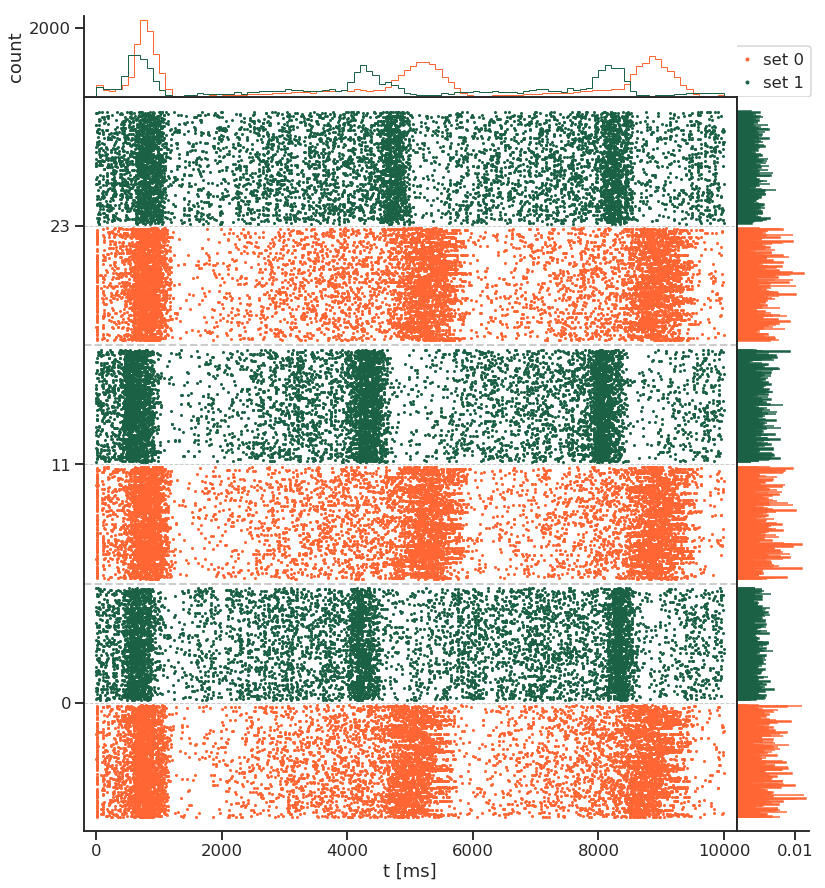

In [56]:
fig, ax = plt.subplots(figsize=(13,15))

viziphant.rasterplot.rasterplot([nest.spiketrains, dpsnn.spiketrains], 
                                key_list=['module', '', 'sub_population'], 
                                colorkey='',
                                legend=True,
                                ax=ax,
                                groupingdepth=2,
                                spacing=20,
                                labelkey='module',
                                context='talk',
                                palette=[nest.params['color'], dpsnn.params['color']]);

#ax.set_yticklabels([nest.name, dpsnn.name], rotation=90, va='center');

## Define tests
For more base tests already implemented refer to [NetworkUnit](https://github.com/INM-6/NetworkUnit).

#### Firing Rate Test

In [57]:
class FR_test_class(sciunit.TestM2M, tests.firing_rate_test):
    score_type = scores.kl_divergence # ks_distance, mwu_statistic, effect_size
    params = {'binsize': 2*pq.ms,
              'kl_binsize':0.1}
    
    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

FR_test = FR_test_class()

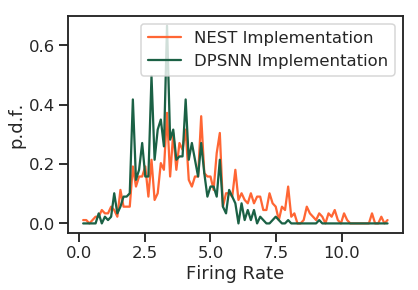

In [58]:
FR_test.visualize_samples(nest, dpsnn, var_name='Firing Rate')
plt.show()

In [59]:
score = FR_test.judge([nest, dpsnn]).iloc[0,1]
print(score)



Kullback-Leibler-Divergence
	datasize: 750 	 750
	discarded: 52
	D_KL = 0.265 	 bins = 115




/home/rgutzen/anaconda3/envs/py36/lib/python3.6/site-packages/sciunit/scores/collections_m2m.py:64: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  self.models = models


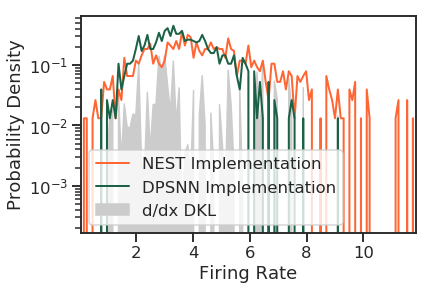

In [60]:
FR_test.visualize_score(nest, dpsnn, var_name='Firing Rate')
plt.show()

#### Power Spectral Density Test

In [77]:
from elephant.statistics import time_histogram
from elephant.spectral import welch_psd


class power_spectrum_test(tests.two_sample_test):
    """
    Test to compare the power spectral density of a set of spiking neurons in a network.
    The statistical testing method needs to be set in form of a
    sciunit.Score as score_type.
    Parameters are passed on to elephant.spectral.welch_psd
    """

    required_capabilities = (capabilities.ProducesSpikeTrains, )

    def generate_prediction(self, model, **kwargs):
        if kwargs:
            self.params.update(kwargs)
        if not hasattr(model, 'prediction'):
            model.prediction = {}
        if self.test_hash in model.prediction:
            psd = model.prediction[self.test_hash]
        else:
            spiketrains = model.produce_spiketrains(**self.params)

            self._set_default_param('binsze', 10*pq.ms)
            self._set_default_param('num_seg', None)
            self._set_default_param('len_seg', None)
            self._set_default_param('freq_res', 1.)
            self._set_default_param('overlap', 0.5)
            self._set_default_param('fs', 100)
            self._set_default_param('window', 'hanning')
            self._set_default_param('nfft', None)
            self._set_default_param('detrend', 'constant')
            self._set_default_param('return_onesided', True)
            self._set_default_param('scaling', 'density')
            self._set_default_param('axis', -1)

            asignal = time_histogram(spiketrains, binsize=self.params['binsize'])
            freqs, psd = welch_psd(asignal,
                                   num_seg=self.params['num_seg'],
                                   len_seg=self.params['len_seg'],
                                   freq_res=self.params['freq_res'],
                                   overlap=self.params['overlap'],
                                   fs=self.params['fs'],
                                   window=self.params['window'],
                                   nfft=self.params['nfft'],
                                   detrend=self.params['detrend'],
                                   return_onesided=self.params['return_onesided'],
                                   scaling=self.params['scaling'],
                                   axis=self.params['axis'])
            model.psd_freqs = freqs
            model.prediction[self.test_hash] = np.squeeze(psd)  #ToDO: PSD samples (ensure same freqs!??)
            # ToDo: How to quantitatively compare PSD distributions ??
        return np.squeeze(psd)

    def _set_default_param(self, pname, value):
        if pname not in self.params:
            self.params[pname] = value
        return None
    

    def visualize_samples(self, model1=None, model2=None, ax=None, bins=100,
                         palette=None, density=True,
                         sample_names=['observation', 'prediction'],
                         var_name='Measured Parameter', **kwargs):

        samples, palette, names = self._create_plotting_samples(model1=model1,
                                                         model2=model2,
                                                         palette=palette)
        if self.observation is None:
            sample_names[0] = model1.name
            freqs1 = model1.psd_freqs
            freqs2 = None
            if model2 is not None:
                sample_names[1] = model2.name
                freqs2 = model2.psd_freqs                
        else:
            sample_names[1] = model1.name
            freqs1 = model1.psd_freqs
            freqs2 = model1.psd_freqs
            

        if len(samples) == 1:
            sample_2 = None
        else:
            sample_2 = samples[1]
        
        self.plot_power_spectral_density(sample1=samples[0], freqs1=freqs1, 
                               sample2=sample_2, freqs2=freqs2, ax=ax, bins=bins,
                               palette=palette, sample_names=sample_names, **kwargs)
        return ax
    
    def plot_power_spectral_density(self, sample1, freqs1, sample2=None, freqs2=None, 
                               ax=None, bins=100, palette=None,
                               sample_names=['observation', 'prediction'],
                               **kwargs):
        if ax is None:
            fig, ax = plt.subplots()
        if palette is None:
            palette = [sns.color_palette()[0], sns.color_palette()[1]]
            
        ax.plot(freqs1, np.squeeze(sample1), color=palette[0], label=sample_names[0])
        
        if sample2 is not None:
            if freqs2 is None:
                freqs2 = freqs1
            ax.plot(freqs2, np.squeeze(sample2), color=palette[1], label=sample_names[1])
            
        ax.set_xlabel('frequency [Hz]')
        ax.set_ylabel('power spectral density')
        ax.set_yscale('log')
        ax.set_xscale('log')
        return ax
    
class power_spectrum_m2m_test(sciunit.TestM2M, power_spectrum_test):
    score_type = scores.ks_distance
    params = {'binsize': 10*pq.ms,
              'freq_res': .5,
              'fs': 100}

In [78]:
PSD_test = power_spectrum_m2m_test()

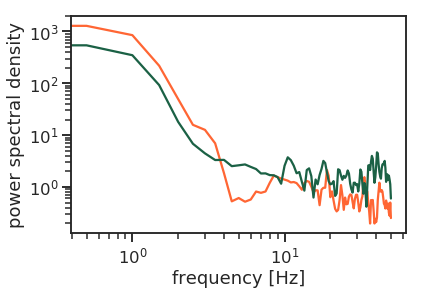

In [79]:
ax = PSD_test.visualize_samples(nest, dpsnn, var_name='')
plt.show()